Notebook 4, Module 2, Statistical Inference for Data Science, CAS Applied Data Science, 2021-09-02, A. Mühlemann, University of Bern.

*This notebook is based on last year's notebook by S. Haug and G. Conti.*

## 4. Hypothesis Testing

Practice various tests with the Python scipy stats module.

**Average expected study time :** 3x45 min (depending on your background)

**Learning outcomes :**

- Know the hypothesis testing vocabulary
- Can check normality based on Q-Q-Plots
- Can perform normality tests of samples (Agostino-Pearson test, Shapiro-Wilk)
- Can perform t-Test on a single sample (testing against a given mean, gaussian)
- Can perform a Wilcoxon on a single sample (testing against a given median, not gaussian, only symmetric assumption)
- Can comparing two groups of data, e.g. treated and control, know which tests are suited for which cases
- Can perform some ANOVA tests

**Bonus skills**
- More Python tricks
- Get to know the Python stats module better: https://docs.scipy.org/doc/scipy/reference/stats.html

**Literature examples**

- https://en.wikipedia.org/wiki/Statistical_hypothesis_testing
- http://greenteapress.com/wp/think-stats-2e/ (online book covering most of the CAS Module 2)

- For life sciences (bioinformatics) for example
https://cran.r-project.org/doc/contrib/Krijnen-IntroBioInfStatistics.pdf
- (Particle) Physics
http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf


In [2]:
#!pip install seaborn --upgrade scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats

## 4.1 Summary of the main points

The hypothesis being tested is called the *null hypothesis*. When doing a statistical test, the test statistic of a sample is calculated and and then we check how probable this value is given the null hypothesis. To this end, we look a the p-value.

More precisely, the p-value is the probability of obtaining such a sample if the null hypothesis is true. A significance level of 5% is often used as the threshold where you say, this is so unlikely that I consider the null hypothesis as wrong. However, 5% still means that this happens in 5 out of 100 times.

Depending on your working hypothesis H1, you are either interested in a one-, or two-sided test. Roughly speaking you'll use a one-tailed (``` greater, less ```) test, when having a hypothesis about the direction of an effect e.g. group 1 is better that group 2. You'll use a two-tailed test (```two-sided```) when you just want to show that the two groups are different. 
For more insight on this, check out this link https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/

In Python (an R) you can adapt the direction of you test with the argument via

```
alternative='two-sided', 'less', 'greater'
```
To avoid confusion the code below below always uses ```alternative='two-sided```.



### Error types and statistical power

- Type I : Reject the null hypothesis due to a fluctuation (false positive)
- Type II : Keep the null hypothesis by interpreting a real effect as a fluctuation (false negative)
- (Type 0 : Make the right conclusion but asking the wrong question)
 
People may talk about the **statistical power** of their experiment. This is a number between 0 and 1 telling how often your experiment would lead to a type II error. So a high power (close to 1) means rare type II errors. The statistical power is infuenced by your significance criterion, the (physical) magnitude of your effect, the sample size ("statistics").

### Many tests

There are many tests on the market and some or most of them are implemented in Python (or R). It is impossible to look at all the tests that exist, since basically for every scenario there is another test. We therefore focus on a few useful cases. You would look up suiteable tests for your analysis. The important thing is to know what a test assumes (distribution etc) and how to interprete the result and if you can trust the result


## 4.2 Normality

There are different approaches to deciding whether the normality assumption is satisfied. There are statistical tests as well as grafical approaches. We first look at a graphical approach named Q-Q-Plot

### 4.2.1 Q-Q-Plot


A Q-Q (quantile-quantile) plot, plots the distribution of the data against the expected normal distribution by comparing their quantiles. For normally distributed data, observations should lie approximately on a straight line. If the data is not normal, the points deviate from a straight line. 

Let us first generate some normal data, to see how a Q-Q-Plot ideally should look like.

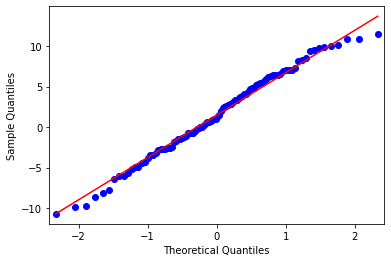

In [3]:
n = 100
np.random.seed(26082021) # By fixing the seed, you can make the generation reproducible
# Generate a data sample of size n
a = np.random.normal(2, 5, size=n)
fig=sm.qqplot(a, line='s')
plt.show()

Now let us check what happens if the normality assumption is certainly violated.

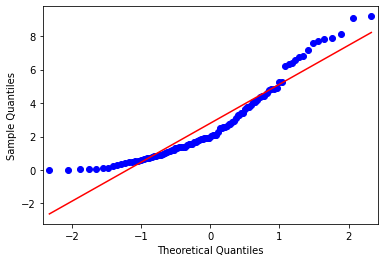

In [4]:
n = 100
np.random.seed(26082021) # By fixing the seed, you can make the generation reproducible
# Generate a data sample of size n from a chi-square distribution
b = np.random.chisquare(df=3, size=n)
fig=sm.qqplot(b, line='s')
plt.show()

Now let us go back to the iris data. The the previous days we suspected that *slength* from of the species *iris virginica* is normally distributed. Let us therefore look at the corresponding Q-Q-Plot.

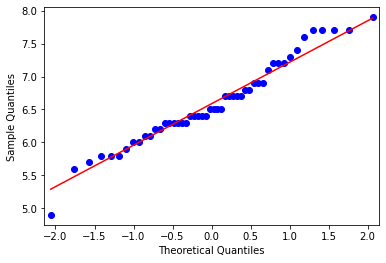

In [5]:
# Load Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url,names=['slength','swidth','plength','pwidth','species'])
# Choose species & slength
df_virginica = df[df['species']=='Iris-virginica']
slength = df_virginica['slength']
# Q-Q-Plot
fig=sm.qqplot(slength, line='s')
plt.show()

The Q-Q-Plot looks quite promising. But there are some outliers. When one is not sure on how the decide, it's helpful go generate some normal samples of the same size and compare their Q-Q-Plots to the one at hand.

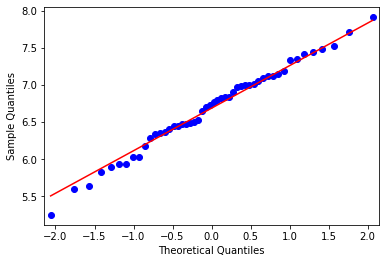

In [32]:
# Generate a data sample of size n
#Theoretische Verteilung simulieren, dann vergleichen
c = np.random.normal(slength.mean(), slength.std(), size=len(slength))
fig=sm.qqplot(c, line='s')
plt.show()

If we rerun the above code several times, it seems that a normality assumption is justified.

### 4.2.2 Normality test

An alternative to Q-Q-Plots is provided by normality tests. 

They can be performed for each column of data. Each normality test reports a p-value that answers this question:

If you randomly sample from a Gaussian population, what is the probability of obtaining a sample that deviates from a Gaussian distribution as much (or more so) as this sample does?

Normality tests are not good for small samples (<10-20 values). You can do it, but the interpration of the output is not straight forward.

There are several normality tests in the Python stats module:
- D’Agostino-Pearson
- Shapiro-Wilk
- Kolomogorv-Smirnov

Many people prefer to use the first one. But the others are also widely used. Personally, I often work with Q-Q-Plots because that way I get a better impression on what areas might be critical and what not. But many people prefer tests because the decision is easier to make, however that may also lead to a false sense of security.

What is a bit different with normality test compared to other tests, is that we cannot test for normality but rather against normality. Meaning that if the p-value is small that indicates that the data is **not** normally distributed. Hence, we are rather hoping for a p-value close to 1.

https://docs.scipy.org/doc/scipy/reference/stats.html


Let us perform the D’Agostino-Pearson test for examples we considered with the Q-Q-Plots. First the data generated from a normal distribution.

In [7]:
k2, p = stats.normaltest(a) # D Agostino-Pearson. The method returns the test statistic value and the p-value
alpha = 0.001 # Rejection criterion defined by you
print('Alpha = ',alpha)
print('p = ',p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
  print("The null hypothesis cannot be rejected")

Alpha =  0.001
p =  0.23116477867149146
The null hypothesis cannot be rejected


This is not very surprising as we generated the data from a normal distribution. Now let us look at the data generated from a Chi-square distribution.

In [8]:
k2, p = stats.normaltest(b) # D Agostino-Pearson. The method returns the test statistic value and the p-value
alpha = 0.001 # Rejection criterion defined by you
print('Alpha = ',alpha)
print('p = ',p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
  print("The null hypothesis cannot be rejected")

Alpha =  0.001
p =  0.0008658946948332712
The null hypothesis can be rejected


Indeed the normality test suggest that we should reject the normality assumption. Finally let us looks again at *slength* from *iris virginica*.

In [9]:
k2, p = stats.normaltest(slength) # D Agostino-Pearson. The method returns the test statistic value and the p-value
alpha = 0.001 # Rejection criterion defined by you
print('Alpha = ',alpha)
print('p = ',p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
  print("The null hypothesis cannot be rejected")

Alpha =  0.001
p =  0.9008201941206306
The null hypothesis cannot be rejected


Considering the Q-Q-Plot we concluded that the normality assumption is justified. The D’Agostino-Pearson test confirms this conclusion.


Let us do one more characteristic together. This time we look at the species *iris setosa* and its characteristic *swidth*.

In [10]:
df_setosa=df[df['species'] == 'Iris-setosa']
dfs = df_setosa['swidth']
print(stats.describe(dfs)) # Print some descriptive statistics
dfs.describe() # the pandas describe prints similar statistics

DescribeResult(nobs=50, minmax=(2.3, 4.4), mean=3.418, variance=0.1451795918367347, skewness=0.1038140820747848, kurtosis=0.6851340609499261)


count    50.000000
mean      3.418000
std       0.381024
min       2.300000
25%       3.125000
50%       3.400000
75%       3.675000
max       4.400000
Name: swidth, dtype: float64

Check the normality of the iris sepal length of species

In [11]:
k2, p = stats.normaltest(dfs) # D Agostino-Pearson test
print("p-value = %1.2f" % p)

p-value = 0.39


What does this p-value mean? If you want to know what the k2 is, look it up in the documentation. What about de other species and characteristics?

We can also try the shapiro test that the stat module offers:

In [12]:
s,p = stats.shapiro(dfs)
print('Test statistic = ',s,' p-value =',p)

Test statistic =  0.968691885471344  p-value = 0.20465604960918427


In this case the shapiro test returns a lower p-value. How should you proceed?

## 4.3 One-sample tests
Having seen how we can check for normality let us introduce the tests seen on the slides.
More details on the specific tests will be given in the presentations tomorrow. Nonetheless it's helpful to have an overview on how the tests are performed. 
To illustrate the 1-sample tests we want to test whether the *true* center of the distribution of *swidth* of *iris setosa* equals $3.3$. 

### 4.3.1 t-Test

With the t-test you can test your data against a normal distribution with a given mean:

If the data were sampled from a Gaussian population with a mean equal to the hypothetical value you entered, what is the chance of randomly selecting N data points and finding a mean as far (or further) from the hypothetical value as observed here?

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest

In [13]:
print('The sample mean of the sepal length = ',dfs.mean())

stats.ttest_1samp(a=dfs,popmean=3.3, alternative='two-sided')

The sample mean of the sepal length =  3.4180000000000006


Ttest_1sampResult(statistic=2.1898492754769694, pvalue=0.033325644557196644)

**Interpretation:** If the real average of the sepal length of setosa leaves is 3.3 cm and if the length of the leaves is normally distributed, the probability of sampling this data or worse data from setosa leaves is 3.3%. So we would reject the null hypothesis on level 95%

Our null hypothesis in this case was a normal distribution with mean equal to 3.3 cm.

### 4.3.2 Wilcoxon signed rank test

If normality is not satisfied but the distribution can be assumed to be symmetric we can perform a one-sample Wilcoxon signed rank test. It works similar to the t-test but we have to subtract the guessed population mean.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon

In [14]:
stats.wilcoxon(dfs-3.3, alternative='two-sided')

WilcoxonResult(statistic=352.0, pvalue=0.01533078537135795)

### 4.3.3 Sign test

If the distribtuion is neither normal nor symmetric we can perform a sign-test. For some reason, only the two-sided version is implemented. But the sign-test is fairly easy to calculate by hand.

https://www.statsmodels.org/stable/generated/statsmodels.stats.descriptivestats.sign_test.html

https://en.wikipedia.org/wiki/Sign_test

In [15]:
import statsmodels.stats.descriptivestats as dstat
dstat.sign_test(dfs, mu0=3.3)

(6.0, 0.11140289106101872)

## 4.4 Two-sample Tests 

In many experiments one uses two groups, a treated group and a control group which is not treated. The goal is then to ckeck the effect of the treatment.

One way to answer this, is to check how much the treated group differs from the control group. Python stats module offer several tests to do this.

If the data is "paired", this can be used in the tests (they get better because there is more "information or structure" in the data). So we need to know what paired data is in order to choose the right test.

**Paired/related data**
- Repeated measurements on the same object/individual, e.g. before and after treatment 

**Unpaired/independent data**
- Independent, e.g. from separate individuals

### 4.4.1 t-test for normally distributed unpaired data with not assuming equal variance

Let us perform a test comparing the sepal width of the setosa and the virginica species. 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind

In [16]:
df_virginica=df[df['species'] == 'Iris-virginica']
df_virginica.head() # Just cheking that we got the right data by looking at the first five (head)

,slength,swidth,plength,pwidth,species
100,6.3,3.3,6.0,2.5,Iris-virginica
101,5.8,2.7,5.1,1.9,Iris-virginica
102,7.1,3.0,5.9,2.1,Iris-virginica
103,6.3,2.9,5.6,1.8,Iris-virginica
104,6.5,3.0,5.8,2.2,Iris-virginica


We did test that the setosa setal width is very normal. Let us also check the virginica setal width.

In [17]:
k2, p = stats.normaltest(df_virginica['swidth']) # D Agostino-Pearson test
print("p-value = %1.2f" % p)

p-value = 0.28


This looks also very normal. How likely is it that these two samples come from a normal sample with the same mean?

In [18]:
stats.ttest_ind(df_setosa['swidth'],df_virginica['swidth'], equal_var = False, alternative='two-sided') # False means we don't assume equal variances (Welsch's t-test)

Ttest_indResult(statistic=6.289384996672061, pvalue=9.58603917037916e-09)

**Interpretation :** It is extremly unlikely that these samples would come from a population with the same mean. 
The sample means were:

In [19]:
print("%1.2f %1.2f" % (df_virginica.mean()['swidth'], df_setosa.mean()['swidth']))

2.97 3.42


### 4.4.2 t-test for normally distributed unpaired data assuming equal variance

In [20]:
stats.ttest_ind(df_setosa['swidth'],df_virginica['swidth'], equal_var = True, alternative='two-sided') # True means we assume equal variances 

Ttest_indResult(statistic=6.289384996672061, pvalue=8.916634067006443e-09)

**Interpretation :** It is extremly unlikely that these samples would come from a population with the same mean and the same variance.

The p-value got slightly worse, but such small p-values have no meaning anyway. p-values below 0.01 are often not that precise. We just know they are below 0.01.




### 4.4.3 Mann-Whitney U for *not* normally distributed unpaired data

Compute the Mann-Whitney U test on samples x and y. Only use with more than 20 data points.
http://localhost:8888/notebooks/work/SDA-4-Hypothesis-Testing.ipynb#t-Test

In [21]:
stats.mannwhitneyu(df_setosa['swidth'],df_virginica['swidth'], alternative='two-sided')

MannwhitneyuResult(statistic=2073.5, pvalue=1.1808768215413658e-08)

Let us do this test with samples from the same population.

In [22]:
print(stats.mannwhitneyu(df_setosa['swidth'][:25],df_setosa['swidth'][25:50], alternative='two-sided'))
print(stats.mannwhitneyu(df_setosa['swidth'][:10],df_setosa['swidth'][40:50], alternative='two-sided'))
print(stats.mannwhitneyu(df_setosa['swidth'][:5],df_setosa['swidth'][45:50], alternative='two-sided'))

MannwhitneyuResult(statistic=365.0, pvalue=0.3101127889935418)
MannwhitneyuResult(statistic=42.5, pvalue=0.595035151629138)
MannwhitneyuResult(statistic=9.0, pvalue=0.5283593272709486)


The p-value varies quite a lot with the size of the samples. Here we would need to study where it gets stable.

Compute the **Kolmogorov-Smirnov** statistic on 2 samples. This is a test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp

In [23]:
stats.ks_2samp(df_setosa['swidth'],df_virginica['swidth'])

KstestResult(statistic=0.5, pvalue=4.8075337049514946e-06)

**Interpretation:** It is very unlikely that these sets come from the same population.

Let's do it on the same population.

In [24]:
print(stats.ks_2samp(df_setosa['swidth'][:25],df_setosa['swidth'][25:50]))
print(stats.ks_2samp(df_setosa['swidth'][:10],df_setosa['swidth'][40:50]))
print(stats.ks_2samp(df_setosa['swidth'][:5],df_setosa['swidth'][45:50]))

KstestResult(statistic=0.2, pvalue=0.7102038997076623)
KstestResult(statistic=0.2, pvalue=0.9944575548290717)
KstestResult(statistic=0.4, pvalue=0.873015873015873)


For both tests we get very small p-values as expected, when the sets are from different species. When we split one of the datasets into two subsets, the p-values are higher. 

### 4.4.4 t-test for normally distributed paired data


Calculate the T-test on TWO RELATED samples. This is a test for the null hypothesis that 2 related or repeated samples have identical average (expected) values.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

Let's test if the swidth and the slength (related/paired) of the setosa sample have identical means. 

In [25]:
stats.ttest_rel(df_setosa['swidth'],df_setosa['slength'], alternative='two-sided')

Ttest_relResult(statistic=-42.799455674951105, pvalue=1.7724677938534975e-40)

As expected the p-value is very small (we know that swidth and slength have very different means). Let's test two subsamples from the same sample:

In [26]:
stats.ttest_rel(df_setosa.iloc[0:25,1:2],df_setosa.iloc[25:50,1:2], alternative='two-sided')


Ttest_relResult(statistic=array([1.08300729]), pvalue=array([0.2895664]))

As expected the p-value is high.

### 4.4.4 Wilcoxon signed-rank test for *not* normally distributed paired data

The Wilcoxon signed-rank test is a non-parametric statistical hypothesis test used to compare two related samples, matched samples, or repeated measurements on a single sample to assess whether their population mean ranks differ (i.e. it is a paired difference test). It can be used as an alternative to the paired Student's t-test, t-test for matched pairs, or the t-test for dependent samples when the population cannot be assumed to be normally distributed.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon

In [27]:
stats.wilcoxon(df_setosa['swidth'],df_setosa['slength'], alternative='two-sided')

WilcoxonResult(statistic=0.0, pvalue=7.392803652204549e-10)

## 4.5 ANOVA tests (analysis of variance)

Python stats module provides a one-way Anova test. The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean (a generalisation of the t-test to more than two samples). The test is applied to samples from two or more groups, possibly with differing sizes. 

Please read the documentation about assumptions before using it: 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html#scipy.stats.f_oneway

In [33]:
f, p_value = stats.f_oneway(df_setosa['swidth'][0:10],df_setosa['swidth'][10:20],df_setosa['swidth'][20:30])
p_value

0.07117940263843624

In [34]:
f, p_value = stats.f_oneway(df_setosa['swidth'],df_virginica['swidth'])
p_value

8.916634067006418e-09

In last example on assumption is not fulfilled. 

### Beyond one-way ANOVA

There are examples and code for two-way, three-way and four-way etc ANOVA out there. We don't have the time to discuss them to practise them today. You can do this example if you like (maybe with Iris data):

http://www.pybloggers.com/2016/03/three-ways-to-do-a-two-way-anova-with-python/

In [30]:
from statsmodels.stats.anova import anova_lm

## 4.5 Final words 

If you are in doubt about your results because you think you have too little data or strangely distributed data you should/could:

- Check by using another tool and see if there are changes in the results
- Manipulate your (test) data (by adding/changing artifical datapoints etc) and study the effect on the result

In the end you should enable people to interprete your results in a correct way and come to the same conclusions as you. So your results should be reproducible within the uncertainties you state.